In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
file_path = '/content/air-quality-india.csv'  # Update path after uploading
df = pd.read_csv(file_path)
print(df.head())

             Timestamp  Year  Month  Day  Hour   PM2.5
0  2017-11-07 12:00:00  2017     11    7    12   64.51
1  2017-11-07 13:00:00  2017     11    7    13   69.95
2  2017-11-07 14:00:00  2017     11    7    14   92.79
3  2017-11-07 15:00:00  2017     11    7    15  109.66
4  2017-11-07 16:00:00  2017     11    7    16  116.50


In [4]:
drop_cols = ['Date', 'Time']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

In [5]:
df_numeric = df.select_dtypes(include=[np.number])

In [6]:
print("Available columns:", df_numeric.columns)

Available columns: Index(['Year', 'Month', 'Day', 'Hour', 'PM2.5'], dtype='object')


In [7]:
df_numeric.replace(-200, np.nan, inplace=True)

In [8]:
print("Missing values before cleaning:\n", df_numeric.isnull().sum())

Missing values before cleaning:
 Year     0
Month    0
Day      0
Hour     0
PM2.5    0
dtype: int64


In [9]:
imputer = SimpleImputer(strategy='mean')
df_numeric.iloc[:, :] = imputer.fit_transform(df_numeric)

In [10]:
num_cols = df_numeric.columns.tolist()

In [11]:
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = ((df_numeric < lower_bound) | (df_numeric > upper_bound)).sum()
print("Outliers before removal:\n", outliers)


Outliers before removal:
 Year       0
Month      0
Day        0
Hour       0
PM2.5    378
dtype: int64


In [12]:
df_numeric = df_numeric[~((df_numeric < lower_bound) | (df_numeric > upper_bound)).any(axis=1)]

In [13]:
skew_kurt_df = pd.DataFrame({'Skewness': df_numeric.skew(), 'Kurtosis': df_numeric.kurt()})
print(skew_kurt_df)

       Skewness  Kurtosis
Year  -0.012562 -0.995438
Month  0.107899 -1.288073
Day   -0.002402 -1.213188
Hour   0.018202 -1.199223
PM2.5  0.626854 -0.284930


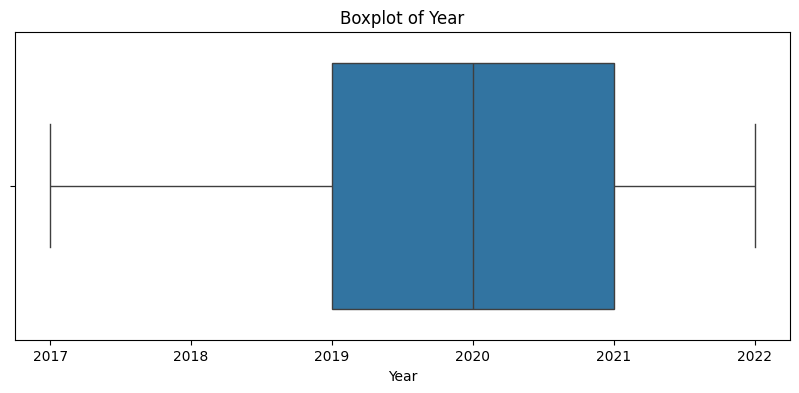

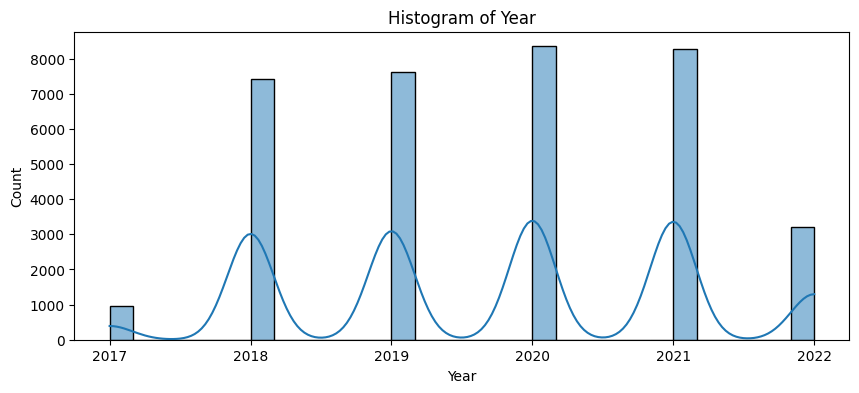

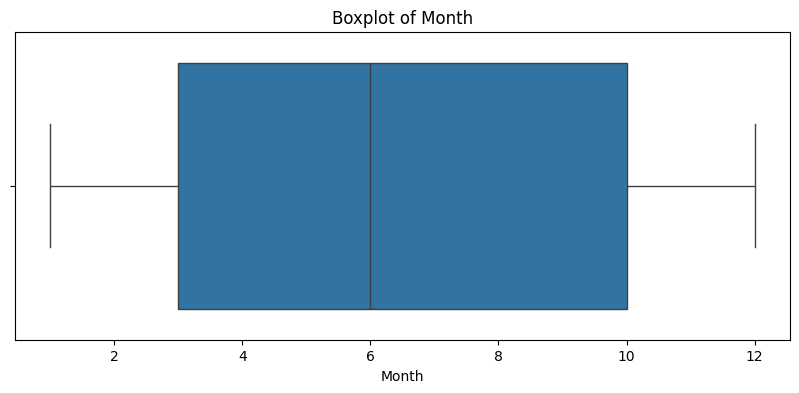

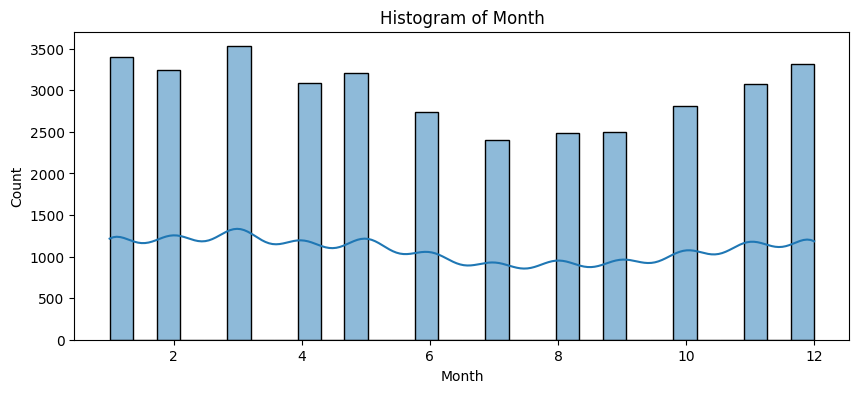

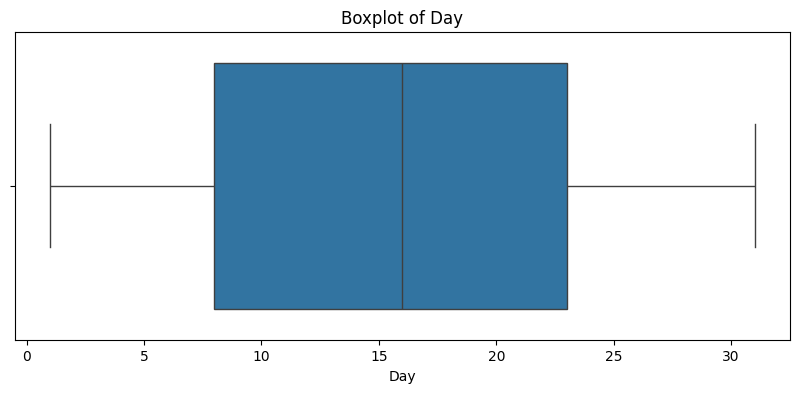

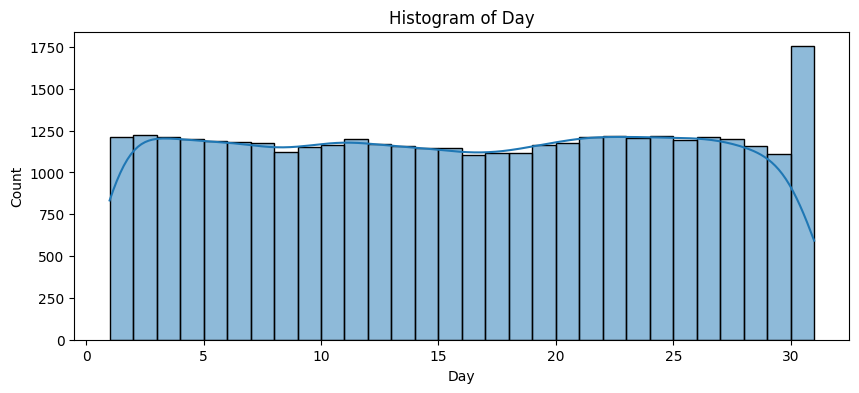

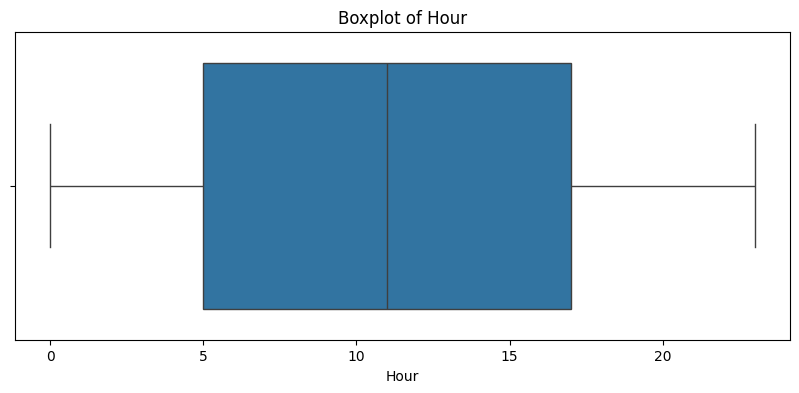

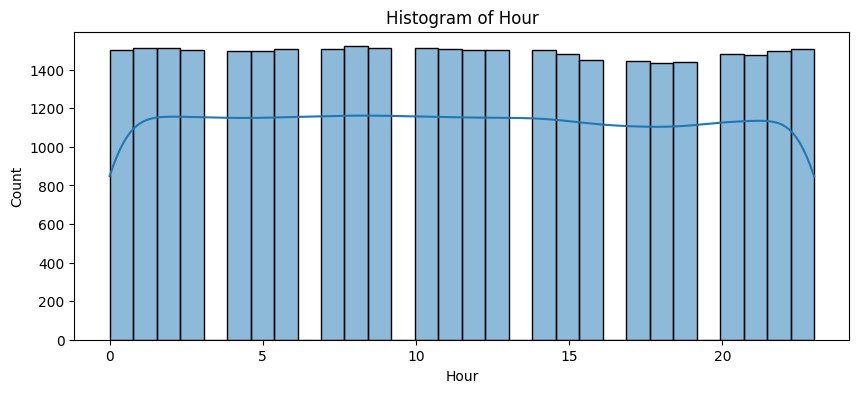

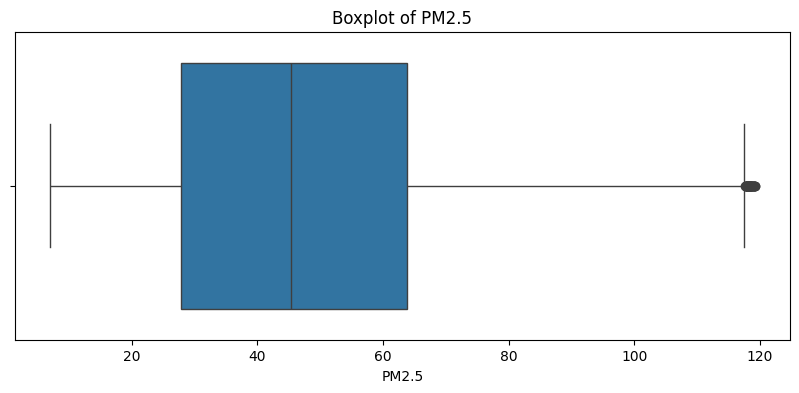

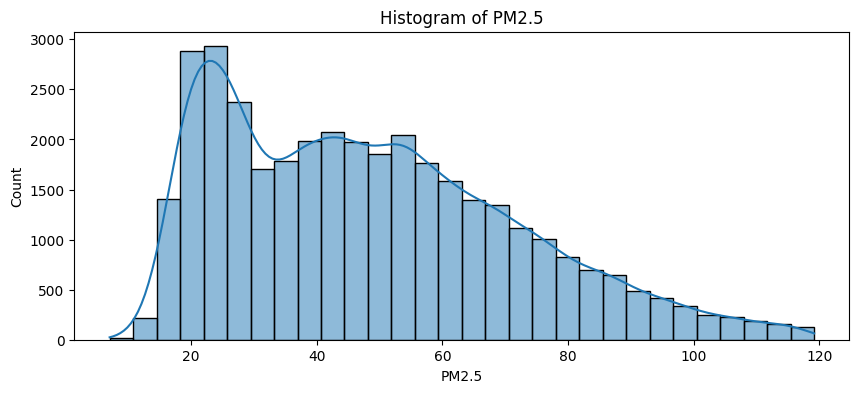

In [14]:
for col in num_cols[:5]:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df_numeric[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

    plt.figure(figsize=(10, 4))
    sns.histplot(df_numeric[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')
    plt.show()


In [15]:
target_column = 'PM2.5'
if target_column not in df_numeric.columns:
    raise ValueError(f"Target column '{target_column}' not found in dataset. Available columns: {df_numeric.columns}")
X = df_numeric.drop(columns=[target_column])
y = df_numeric[target_column]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2 Score': r2_score(y_test, y_pred)
    }


In [19]:
results_df = pd.DataFrame(results).T
print(results_df)

                         MAE         MSE       RMSE  R2 Score
Linear Regression  19.075868  517.819767  22.755654  0.042387
Random Forest       2.581108   16.698406   4.086368  0.969119
XGBoost             3.890394   30.861306   5.555295  0.942928


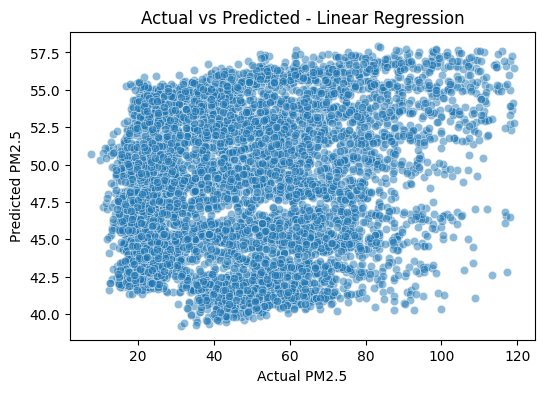

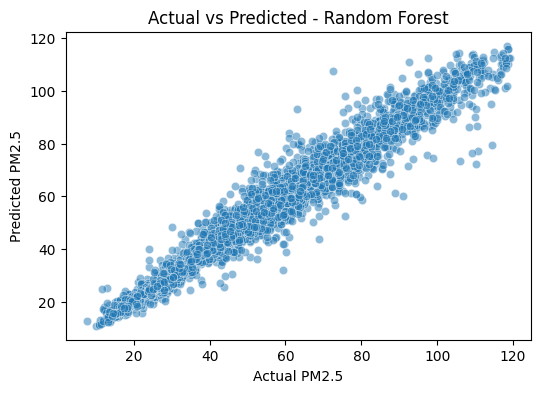

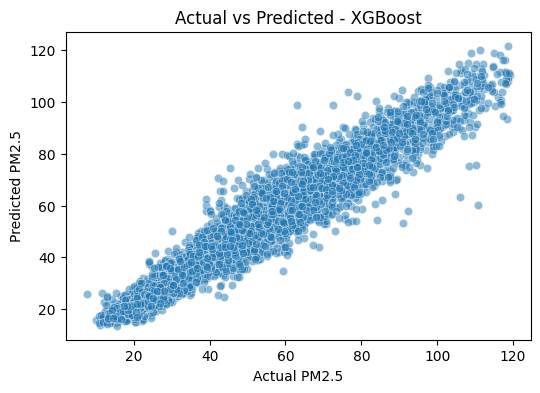

In [20]:
for name, model in models.items():
    y_pred = model.predict(X_test)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.xlabel(f'Actual {target_column}')
    plt.ylabel(f'Predicted {target_column}')
    plt.title(f'Actual vs Predicted - {name}')
    plt.show()